In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import *
from sklearn.preprocessing import MultiLabelBinarizer
import bottleneck as bn
from tqdm import tqdm
from collections import defaultdict
import pickle

In [21]:
users = load_npz('train.npz')
# users = load_npz('test.npz')
B = load_npz('B_movielens.npz')

NUM_ACTIONS = 20

In [11]:
context_lengths = []
for u in tqdm(users):
    context_lengths.append(csr_matrix.count_nonzero(u))
context_lengths = np.array(context_lengths)

116477it [00:05, 20011.59it/s]


### Analysis
To trim down number of users based on context length

Result: ~10k users with a context lengths of [10, 11, 12, 13, 14, 15], `user_trimmed` contains those users used for experiments going forward

Max user context = 3177; 	 Min user context = 0; 	 Mean user context = 71.26276432257012


Text(0.5, 0, 'Context length')

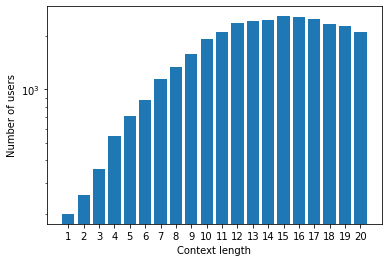

In [17]:
# User context lengths -- some stats
print(f"Max user context = {np.max(context_lengths)}; \t Min user context = {np.min(context_lengths)}; \t Mean user context = {np.mean(context_lengths)}")

# User context lengths up till 10
topk = 20
context_lengths_top = []
for i in range(topk):
    context_lengths_top.append(len(context_lengths[context_lengths == i+1]))

_ = plt.bar(range(1,topk+1), context_lengths_top)
_ = plt.xticks(range(1,topk+1))
plt.yscale('log')
plt.ylabel('Number of users')
plt.xlabel('Context length')

In [19]:
trimmed_context_lengths = [10, 11, 12, 13, 14, 15]
# Pick the users with decided context length
trim_idx = [csr_matrix.count_nonzero(u) in trimmed_context_lengths for u in users]
users_trimmed = users[trim_idx]

### Create trimmed action set
Filtered user preferences still computed with global `B` and thus the user context dimension stays the same

In [22]:
user_action_set = defaultdict()
# user_ids = list(range(X_trimmed.shape[0]))
i = 0
for x in users_trimmed:
    user_score = (x @ B).toarray()[0]
    user_score[x.nonzero()[1]] = -np.inf
    action_idx = (-user_score).argpartition(NUM_ACTIONS)[:NUM_ACTIONS]
    # Filter out users that have no non-zero gt scores
    if np.sum(user_score[action_idx]) == 0:
        print("hmm")
        continue
    user_action_set[i] = list(zip(action_idx, user_score[action_idx]))
    i += 1 

In [24]:
# Dump to a file for user conditioned policies and rewards
f = open(f'user_action_set_historylength.pkl', 'wb')
pickle.dump(user_action_set, f)
f.close()